In [9]:
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib
import copy

### Визуализация траекторий

In [10]:
def get_colors(distances, alpha=True):
    normed = np.array(distances) - np.min(distances)
    normed = normed / np.max(normed)
    alpha = 1/np.mean([len(row) for row in normed])**0.5 if alpha else 1.
    return [[((1. if n > 0.5 else 2 * n), (1. if n < 0.5 else 2 - 2*n), 0., alpha) 
             for n in row] for row in normed]

def get_coords(points):
    results = []
    for pts in points:
        x_prev, _ = pts[0]
        result = [pts[0]]
        for x, y in list(pts[1:]) + [pts[0]]:
            result.append((x_prev, y))
            result.append((x, y))
            x_prev = x
        results.append(list(zip(*result)))
    return results

def init_figure(X):
    upper_bound, lower_bound = X.max(axis=0) + 1, X.min(axis=0) - 1
    fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1)
    #ax.set_facecolor((0.1, 0.1, 0.1))
    ax.grid(True)
    #ax.grid(True, color=(0.9, 0.9, 0.9))
    ax.set_xticks(range(lower_bound[0], upper_bound[0]))
    ax.set_yticks(range(lower_bound[1], upper_bound[1]))
    ax.set_xlim(lower_bound[0], upper_bound[0])
    ax.set_ylim(lower_bound[1], upper_bound[1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.scatter(X[:, 0], X[:, 1], color=(0, 0, 1))
    plt.tight_layout()
    return fig, ax    

def visualize_hillclimb(X, hillclimb):
    fig, ax = init_figure(X)
    permutations = hillclimb.optimize_explain(X)    
    colors = get_colors([[cyclic_distance(X[p], hillclimb.dist) for p in permutations]], False)[0]
    coords = get_coords([X[p] for p in permutations])
    plot = ax.plot(coords[0][0], coords[0][1], color=colors[0])[0]
    
    def animate(i):
        plot.set_color(colors[i])
        plot.set_data(*coords[i])
        return (plot,)
    
    return animation.FuncAnimation(fig, animate, frames=len(permutations), interval=100, blit=True)

### Метрики

In [11]:
def cyclic_distance(points, dist):
    distance = 0
    points_2 = np.concatenate((points[-1].reshape(1, -1), points[:-1]), axis=0)    
    for i in range(len(points)):
        distance += dist(points[i], points_2[i])
    return distance
    
    
def l2_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))
#     return np.linalg.norm((p1 - p2), ord=2)


def l1_distance(p1, p2):
    return np.sum(np.abs(p1 - p2))
#     return np.linalg.norm((p1 - p2), ord=1)

### HillClimb

In [12]:
class HillClimb:
    def __init__(self, max_iterations, dist):
        self.max_iterations = max_iterations
        self.dist = dist
        
    
    def optimize(self, X):
        return self.optimize_explain(X)[-1]
    
    
    def optimize_explain(self, X):
        n = X.shape[0]
        story_perm = np.expand_dims(np.linspace(0, n-1, n, dtype=int), axis=0)
        story_dist = [cyclic_distance(X, self.dist)]
        
        for _ in range(self.max_iterations):
            ind = story_perm[-1]
            ind_dist = story_dist[-1]
            best_ind = None
            best_dist = ind_dist
#             print('curr_best:', cyclic_distance(copy.deepcopy(X)[ind], self.dist))
            
            for i in range(n-1):
                for j in range(i+1, n):
                    _ind = copy.deepcopy(ind)
                    _dist = copy.deepcopy(ind_dist)
                    new_dist, new_ind = self.rebuid_dist(n, i, j, _ind, _dist, X)
#                     print(new_dist)
                    if new_dist < best_dist:
                        best_dist = new_dist
                        best_ind = new_ind

            if best_ind is None:
                break
                      
            story_perm = np.concatenate((story_perm, np.expand_dims(best_ind, axis=0))) 
            story_dist.append(best_dist)
                
        return story_perm
    
    
    def rebuid_dist(self, n, i, j, ind, dist, X):
        #old
        d1 = self.dist(X[ind[i]], X[ind[i-1]])
        d2 = self.dist(X[ind[i]], X[ind[(i+1)%n]])
                    
        d3 = self.dist(X[ind[j]], X[ind[j-1]])
        d4 = self.dist(X[ind[j]], X[ind[(j+1)%n]])
                    
        new_dist = dist - ((d1 + d2) + (d3 + d4))
        ind[i], ind[j] = ind[j], ind[i]
                    
        #new
        d1_new = self.dist(X[ind[i]], X[ind[i-1]])
        d2_new = self.dist(X[ind[i]], X[ind[(i+1)%n]])
                    
        d3_new = self.dist(X[ind[j]], X[ind[j-1]])
        d4_new = self.dist(X[ind[j]], X[ind[(j+1)%n]])
                    
        new_dist += ((d1_new + d2_new) + (d3_new + d4_new))   
        
        return new_dist, ind

### Проверка на синтетическом датасете

In [15]:
def synthetic_points(count=25, dims=2):
    return np.random.randint(40, size=(count, dims))

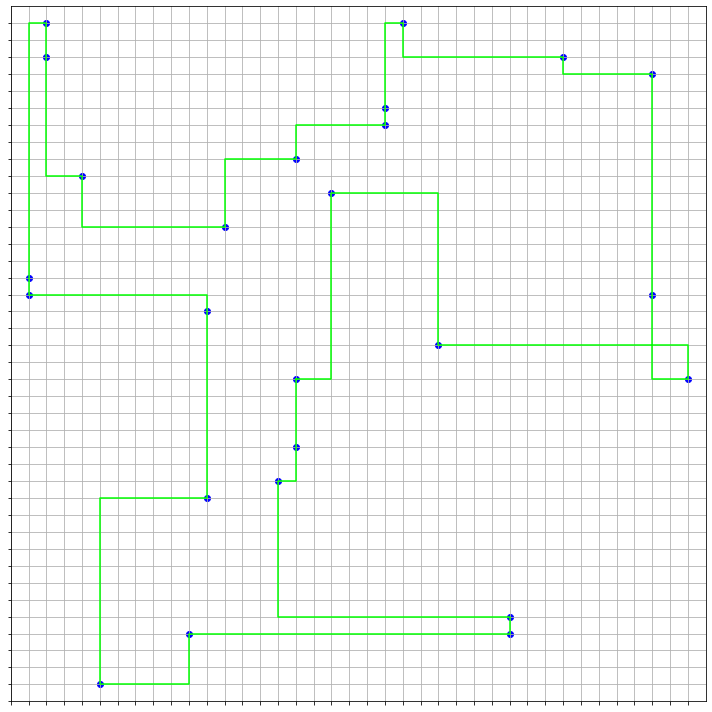

In [16]:
X = synthetic_points()
hc = HillClimb(100, l1_distance)
HTML(visualize_hillclimb(X, hc).to_jshtml())